In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
from matplotlib.collections import PatchCollection
from cmcrameri import (
    cm,
)  # IMPORT SCIENTIFIC HEATMAPS (https://www.fabiocrameri.ch/ws/media-library/ce2eb6eee7c345f999e61c02e2733962/readme_scientificcolourmaps.pdf#page=10.63)
import matplotlib.colors as mplcolors
import seaborn as sns
import ast

import os
import pyminizip
from pathlib import Path
import json
import langdetect

import load_questions
pd.set_option('display.max_colwidth', 2000)  # Set max width to 50 characters
pd.options.display.max_rows = 1500


import warnings
warnings.filterwarnings('ignore')

In [151]:
used_models = {
    "Llama_3.3_70B": 'Llama-3.3-70B-Instruct',
    "GPT_4o": "gpt-4o-2024-05-13",
}

metrics = {
    "BLEU": "bleu_score",
    "chrf": "chrf_score",
    "Exact Match": "exact_match_score",
}


In [152]:
result_dfs = []
subquestion_dfs = []

def leval(x):
    try:
        return ast.literal_eval(x)
    except:
        return eval(x)

for model, name in used_models.items():
    print(name)
    try:
        responses = pd.read_csv("../data/scores_og/" + name + "_lingoly_nocontext.csv")
        print(responses.shape)
    except:
        print(f"No scores found for model: {name}. skipping")
        continue

    responses.set_index(["obfuscated_question_n","question_n"], inplace=True)

    responses["model_name"] = model
    
    responses["exact_match_score"] = responses["exact_match_score"].apply(
        lambda x: ast.literal_eval(x)
    )
    responses["model_answers"] = responses["model_answers"].apply(
        lambda x: ast.literal_eval(x)
    )
    responses["correct_answers"] = responses["correct_answers"].apply(
        lambda x: ast.literal_eval(x)
    )
    #responses["correct_answers"] = correct_answers[:len(responses)]

    responses["bleu_score"] = responses["bleu_score"].apply(
        lambda x: leval(x)
    )
    #responses["rouge_score"] = responses["rouge_score"].apply(
    #    lambda x: leval(x)
    #)
    responses["chrf_score"] = responses["chrf_score"].apply(
        lambda x: leval(x)
    )

    # Remove questions where there is no correct answer provided
    responses = responses[
        ~responses["correct_answers"].apply(lambda x: "" in x.values())
    ]

    subquestions_df = pd.DataFrame(
        columns=[
            "split_key",
            "obfuscated_question_n",
            "question_n", 
            "model_name",
            "overall_question_n",
            "obfuscated",
            "question",
            "subquestion",
            "correct_answer",
            "model_answer",
            "model_raw_response",
            "model_answers_extracted",
            "exact_match_score",
            "bleu_score",
            #"rouge_score",
            "chrf_score",
        ],
        data=responses.apply(
            lambda x: [
                (
                    x.split_key,
                    x.name[0], #obfuscated_question_n
                    x.name[1], # question_n
                    x.model_name,
                    x.overall_question_n,
                    x.obfuscated,
                    x["questions"],
                    list(x["correct_answers"].keys())[i],
                    list(x["correct_answers"].values())[i],
                    list(x["model_answers"].values())[i],
                    str(x.model_raw_response),
                    str(x.model_answers_extracted),
                    float(x["exact_match_score"][i]),
                    float(x["bleu_score"][i]),
                    #float(x["rouge_score"][i]),
                    float(x["chrf_score"][i]),
                )
                for i, j in enumerate(x["correct_answers"])
            ],
            axis=1,
        ).values.sum(),
    )

    subquestion_dfs.append(subquestions_df)
    result_dfs.append(responses)

subquestion_dfs = pd.concat(subquestion_dfs)
result_dfs = pd.concat(result_dfs)


subquestion_dfs.shape

Llama-3.3-70B-Instruct
(4698, 16)
gpt-4o-2024-05-13
(4698, 16)


(54650, 15)

In [153]:
# Language of correct answer analysis

from tqdm import tqdm
tqdm.pandas()



def detect_lang(x):
    if x == "":
        return "NA"
    else:
        try:
            return detect(x)
        except:
            return "ERROR"


def ans_type(x):
    if x.lower() in ['yes', 'no', 'true', 'false']:
        return "Y/N"
    if x.isdigit():
        return "Digit"
    if len(x.strip()) == 1:
        return "Single Char"
    return "Other"

subquestion_dfs['ans_len'] = subquestion_dfs['correct_answer'].apply(lambda x: len(str(x)))
subquestion_dfs['ans_type'] = subquestion_dfs['correct_answer'].apply(ans_type)

## Data validation / QA

In [154]:
# Check empty responses
print(sum(subquestion_dfs['model_answer'] == 'nan'))
empty_answer = subquestion_dfs['model_answer'] == ''
empty_raw_answer = subquestion_dfs['model_raw_response'] == 'nan'
subquestion_dfs['empty_answer'] = empty_answer
subquestion_dfs['empty_raw_answer'] = empty_raw_answer



#retrieved = subquestion_dfs['model_answer_retrieved'] != ''
#still_empty = (empty_answer) & (~retrieved)

#subquestion_dfs[empty_answer & retrieved][['subquestion','correct_answer','model_raw_response','model_answer','model_answer_extracted','model_answer_retrieved']]

print(f"Empty model answer: {subquestion_dfs[empty_answer].shape[0]}")

#print(f"Retrieved empty answer: {subquestion_dfs[empty_answer & retrieved].shape[0]}")

#print(f"Still empty: {subquestion_dfs[still_empty].shape[0]}")
print(f"Still empty because no raw response: {subquestion_dfs[empty_answer & empty_raw_answer].shape[0]}")


# When we have a model answer, does the retreived one matches?
#different_retrieved = subquestion_dfs['model_answer'] != subquestion_dfs['model_answer_retrieved']
#print(subquestion_dfs[~empty_answer & retrieved & different_retrieved][view_cols + ['model_answer', 'model_answer_retrieved']].shape)


#filtered = subquestion_dfs[~still_empty]
#filtered = subquestion_dfs.copy()

print()
print("Remaining empty data by model:")
empty_df = subquestion_dfs[empty_answer]
print(f"{empty_df.shape[0] / subquestion_dfs.shape[0] * 100 :2.2f}%")
empty_df.groupby('model_name').size()

2
Empty model answer: 24277
Still empty because no raw response: 19696

Remaining empty data by model:
44.42%


model_name
GPT_4o           19696
Llama_3.3_70B     4581
dtype: int64

In [155]:
# counts of entries 
subquestion_dfs.groupby(['model_name','obfuscated'])[list(metrics.values())].count()

bleu_score  chrf_score  exact_match_score
model_name    obfuscated                                           
GPT_4o        False             1005        1005               1005
              True             26320       26320              26320
Llama_3.3_70B False             1005        1005               1005
              True             26320       26320              26320

In [156]:
# Scores overall
subquestion_dfs.groupby(['model_name','obfuscated'])[['exact_match_score']].agg('mean')

exact_match_score
model_name    obfuscated                   
GPT_4o        False                0.075622
              True                 0.021733
Llama_3.3_70B False                0.045771
              True                 0.030205

In [157]:
# Add a dark grid
import seaborn as sns
#sns.set_theme(style="darkgrid")


def bar_plot(filtered, plot_metric = 'rouge_score', q_num = None, hue="obfuscated", x_col ="model_name", out_suffix=""):
    prob = "All"
    if q_num:
        filtered = filtered[filtered['overall_question_n'] == q_num]
        prob = q_num

    # Create and display the plot
    ax = sns.barplot(x=x_col,
                y=plot_metric,
                hue=hue,
                #edgecolor="k",
                data=filtered,
                palette="Set1",
                width=0.5)
    title = f"{plot_metric} by model. Problem: {prob}. {out_suffix}"
    ax.bar_label(ax.containers[0], rotation='vertical')
    ax.bar_label(ax.containers[1], rotation='vertical')
    plt.grid(color='gray', alpha=.2, axis='y')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.savefig(f'../data/img/{title}.png', bbox_inches='tight')
    plt.show()


def stacked_bar(data, plot_metric = 'rouge_score'):
    colors = ['green', 'lightgreen', 'blue', 'lightblue', 'red'] ## Colors for the bars

    data = data['model_name', 'obfuscated', 'rouge_score'][:1000].copy()
    data.set_index('model_name').plot(y=plot_metric,  kind='bar', stacked=True, width=0.5, color=colors) ## Plot
    plt.ticklabel_format(style='plain', useOffset=False, axis='y') ## No offset
    plt.gca().set_ylabel("Total $'s") ## Set Y-axis

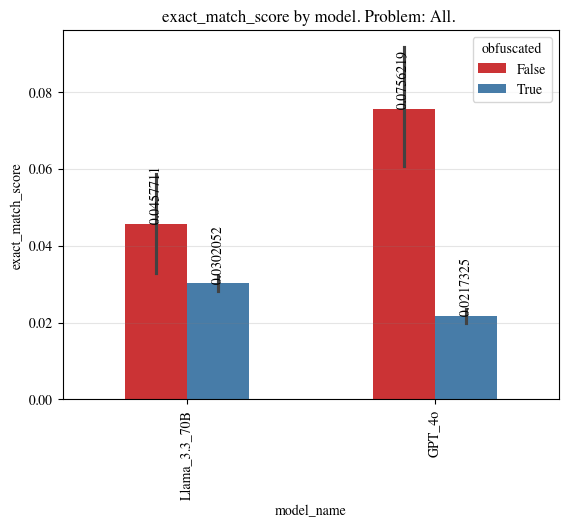

In [158]:
bar_plot(subquestion_dfs, 'exact_match_score')

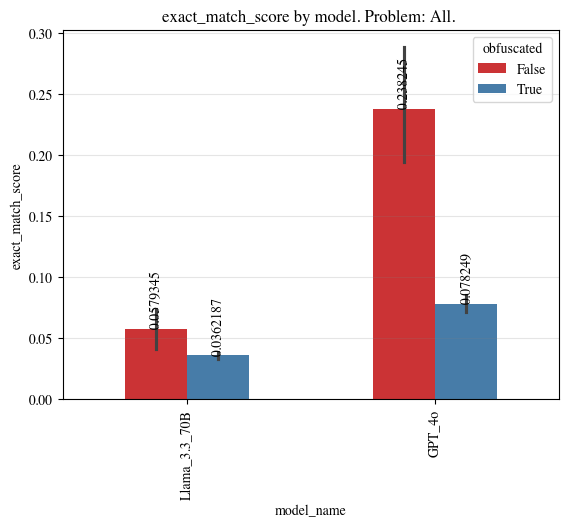

In [159]:
bar_plot(subquestion_dfs[~empty_answer], 'exact_match_score')

In [12]:
#bar_plot(subquestion_dfs, 'chrf_score')

## Analyze Obfuscation delta

In [160]:

# get difference between original question and obfuscated
og_df = subquestion_dfs[~subquestion_dfs['obfuscated']]
obf_df = subquestion_dfs[subquestion_dfs['obfuscated']]


# merge 
merge_cols = ['overall_question_n', 'question_n','subquestion','model_name']
merged = og_df.merge(obf_df, on=merge_cols, suffixes=['_og', '_obf'], validate='one_to_many')

# get the data of questions that unchanged
merged['answer_obf_changed'] = merged['correct_answer_og'] != merged['correct_answer_obf']
merged['model_answer_obf_changed'] = merged['model_answer_og'] != merged['model_answer_obf']

merged.shape

(52640, 36)

In [161]:
merged.groupby(['answer_obf_changed', 'empty_answer_obf']).size()

answer_obf_changed  empty_answer_obf
False               False               14785
                    True                 9305
True                False               14475
                    True                14075
dtype: int64

In [162]:
merged.groupby(['model_name', 'empty_answer_obf']).size()

model_name     empty_answer_obf
GPT_4o         False                7310
               True                19010
Llama_3.3_70B  False               21950
               True                 4370
dtype: int64

In [163]:
# Latex table

print(merged.groupby(['model_name'])[['exact_match_score_og','exact_match_score_obf']].mean().to_latex(index=True, 
                                                                                                                          escape=True, 
                                                                                                                          formatters={"exact_match_score_og":"{:.2f}",
                                                                                                                                     "exact_match_score_obf":"{:.2f}"}))

\begin{tabular}{lrr}
\toprule
 & exact\_match\_score\_og & exact\_match\_score\_obf \\
model_name &  &  \\
\midrule
GPT\_4o & 0.08 & 0.02 \\
Llama\_3.3\_70B & 0.05 & 0.03 \\
\bottomrule
\end{tabular}



In [164]:
# Counts of answer types

total = 26320

merged.groupby(['model_name', 'ans_type_obf']).count() / total * 100

split_key_og  obfuscated_question_n_og  \
model_name    ans_type_obf                                           
GPT_4o        Digit            13.871581                 13.871581   
              Other            71.565350                 71.565350   
              Single Char      13.955167                 13.955167   
              Y/N               0.607903                  0.607903   
Llama_3.3_70B Digit            13.871581                 13.871581   
              Other            71.565350                 71.565350   
              Single Char      13.955167                 13.955167   
              Y/N               0.607903                  0.607903   

                            question_n  overall_question_n  obfuscated_og  \
model_name    ans_type_obf                                                  
GPT_4o        Digit          13.871581           13.871581      13.871581   
              Other          71.565350           71.565350      71.565350   
              Single Char    13.955167           13.955167      13.955167   
              Y/N             0.607903            0.607903       0.607903   
Llama_3.3_70B Digit          13.871581           13.871581      13.871581   
              Other          71.565350           71.565350      71.565350   
              Single Char    13.955167           13.955167      13.955167   
              Y/N             0.607903            0.607903       0.607903   

                            question_og  subquestion  correct_answer_og  \
model_name    ans_type_obf                                                
GPT_4o        Digit           13.871581    13.871581          13.871581   
              Other           71.565350    71.565350          71.565350   
              Single Char     13.955167    13.955167          13.955167   
              Y/N              0.607903     0.607903           0.607903   
Llama_3.3_70B Digit           13.871581    13.871581          13.871581   
              Other           71.565350    71.565350          71.565350   
              Single Char     13.955167    13.955167          13.955167   
              Y/N              0.607903     0.607903           0.607903   

                            model_answer_og  model_raw_response_og  ...  \
model_name    ans_type_obf                                          ...   
GPT_4o        Digit               13.871581              13.871581  ...   
              Other               71.565350              71.565350  ...   
              Single Char         13.955167              13.955167  ...   
              Y/N                  0.607903               0.607903  ...   
Llama_3.3_70B Digit               13.871581              13.871581  ...   
              Other               71.565350              71.565350  ...   
              Single Char         13.955167              13.955167  ...   
              Y/N                  0.607903               0.607903  ...   

                            model_raw_response_obf  \
model_name    ans_type_obf                           
GPT_4o        Digit                      13.871581   
              Other                      71.565350   
              Single Char                13.955167   
              Y/N                         0.607903   
Llama_3.3_70B Digit                      13.871581   
              Other                      71.565350   
              Single Char                13.955167   
              Y/N                         0.607903   

                            model_answers_extracted_obf  \
model_name    ans_type_obf                                
GPT_4o        Digit                           13.871581   
              Other                           71.565350   
              Single Char                     13.955167   
              Y/N                              0.607903   
Llama_3.3_70B Digit                           13.871581   
              Other                           71.565350   
              Single Char                

In [165]:
# Latex table

print(merged.groupby(['model_name', 'ans_type_obf'])[['exact_match_score_og','exact_match_score_obf']].mean().to_latex(index=True, 
                                                                                                                          escape=True, 
                                                                                                                          formatters={"exact_match_score_og":"{:.2f}",
                                                                                                                                     "exact_match_score_obf":"{:.2f}"}))

\begin{tabular}{llrr}
\toprule
 &  & exact\_match\_score\_og & exact\_match\_score\_obf \\
model_name & ans_type_obf &  &  \\
\midrule
\multirow[t]{4}{*}{GPT\_4o} & Digit & 0.16 & 0.08 \\
 & Other & 0.07 & 0.01 \\
 & Single Char & 0.03 & 0.03 \\
 & Y/N & 0.62 & 0.31 \\
\cline{1-4}
\multirow[t]{4}{*}{Llama\_3.3\_70B} & Digit & 0.19 & 0.11 \\
 & Other & 0.02 & 0.01 \\
 & Single Char & 0.05 & 0.04 \\
 & Y/N & 0.19 & 0.49 \\
\cline{1-4}
\bottomrule
\end{tabular}



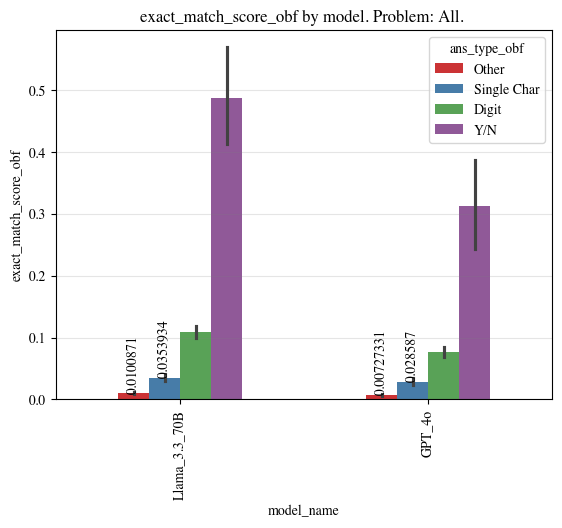

In [166]:
# Breakdown by if obfuscation actually changed the answer
bar_plot(merged, 'exact_match_score_obf', hue='ans_type_obf')

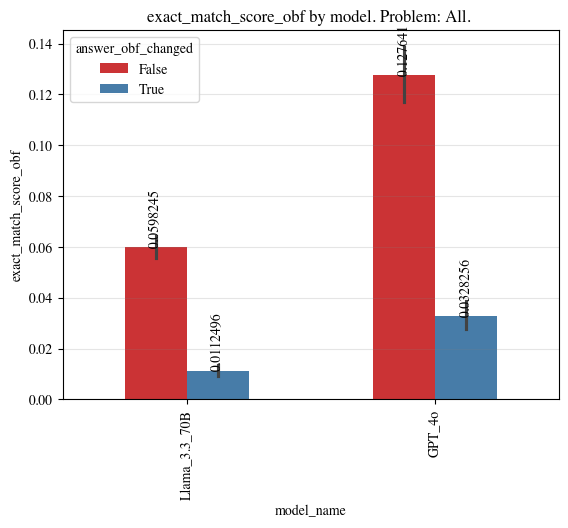

In [167]:
# What if we exclude all empty answers and only score valid attempts?
bar_plot(merged[~merged['empty_answer_obf']], 'exact_match_score_obf', hue='answer_obf_changed')

In [168]:
# Mean and standard error by answer type
merged.groupby(['model_name', 'ans_type_obf'])[['exact_match_score_og', 'exact_match_score_obf']].agg(['mean','sem'])

exact_match_score_og            \
                                           mean       sem   
model_name    ans_type_obf                                  
GPT_4o        Digit                    0.164339  0.006134   
              Other                    0.070132  0.001861   
              Single Char              0.031310  0.002874   
              Y/N                      0.625000  0.038393   
Llama_3.3_70B Digit                    0.188989  0.006480   
              Other                    0.020493  0.001032   
              Single Char              0.046828  0.003486   
              Y/N                      0.187500  0.030954   

                           exact_match_score_obf            
                                            mean       sem  
model_name    ans_type_obf                                  
GPT_4o        Digit                     0.076691  0.004405  
              Other                     0.007273  0.000619  
              Single Char               0.028587  0.002750  
              Y/N                       0.312500  0.036759  
Llama_3.3_70B Digit                     0.108737  0.005153  
              Other                     0.010087  0.000728  
              Single Char               0.035393  0.003049  
              Y/N                       0.487500  0.039640

In [169]:
# Inspect
ans_changed = merged['answer_obf_changed']
correct_og = merged['exact_match_score_og'] == 1.0
wrong_obf = merged['exact_match_score_obf'] == 0.0

view_cols = ['model_name', 'question_og', 'subquestion', 'correct_answer_og', 'model_answer_og', 'correct_answer_obf', 'model_answer_obf']

merged[ans_changed & correct_og & wrong_obf][view_cols].sample(40)

,model_name,question_og,subquestion,correct_answer_og,model_answer_og,correct_answer_obf,model_answer_obf
37445,GPT_4o,"Below is a problem sheet from a lingusitics exam. You will first see the entire sheet, then be asked to respond to specific questions from the sheet. Your answers to the questions should rely only on reasoning about the information provided in the sheet.\n Problem 4. Language X mutants (10 marks)\n \n \n \nWhich is the correct Language X translation of each of the following English sentences? Give only the letter of the correct sentence.\n1. He saw a bicycle in the street: a. Gwelodd beic yn y stryd, b. Gwelodd feic yn y stryd, c. Gwelodd yn y stryd beic, d. Gwelodd yn y stryd feic\n2. In the street, he saw a bicycle: a. Gwelodd yn y stryd feic, b. Gwelodd yn y stryd beic, c. Gwelodd beic yn y stryd, d. Gwelodd feic yn y stryd\n3. In the theatre, she saw a horse: a. Gwelodd yn y theatr geffyl, b. Gwelodd ceffyl yn y theatr, c. Gwelodd yn y theatr ceffyl, d. Gwelodd geffyl yn y theatr \n4. The boy’s father saw a dog: a. Gwelodd dad y bachgen gi, b. Gwelodd tad y bachgen gi, c. Gwelodd tad y bachgen ci, d. Gwelodd dad y bachgen ci \n\nTranslate the following sentences into Language X. (Note: there is no Language X word for ‘a’.)\n5. Here is [a] dragon\n6. The boy saw [a] cat\n7. The man saw [a] doctor\n8. [A] doctor went to Wales\n9. [A] dragon saw [a] doctor\n10. [A] doctor saw [a] dragon\n\n \n\n Now respond to the following questions:\n \nTranslate the following sentences into Language X. (Note: there is no Language X word for ‘a’.)\n5. Here is [a] dragon\n6. The boy saw [a] cat\n7. The man saw [a] doctor\n8. [A] doctor went to Wales\n9. [A] dragon saw [a] doctor\n10. [A] doctor saw [a] dragon\n\n\n Only respond with json output. Do not include anything other than the json in your response. Format your response as a json file with the keys as provided below:\n {""5."": """", ""6."": """", ""7."": """", ""8."": """", ""9."": """", ""10."": """"}\n",9.,Gwelodd draig feddyg,Gwelodd draig feddyg,Gwychef bffuag ddyfog,
37452,GPT_4o,"Below is a problem sheet from a lingusitics exam. You will first see the entire sheet, then be asked to respond to specific questions from the sheet. Your answers to the questions should rely only on reasoning about the information provided in the sheet.\n Problem 4. Language X mutants (10 marks)\n \n \n \nWhich is the correct Language X translation of each of the following English sentences? Give only the letter of the correct sentence.\n1. He saw a bicycle in the street: a. Gwelodd beic yn y stryd, b. Gwelodd feic yn y stryd, c. Gwelodd yn y stryd beic, d. Gwelodd yn y stryd feic\n2. In the street, he saw a bicycle: a. Gwelodd yn y stryd feic, b. Gwelodd yn y stryd beic, c. Gwelodd beic yn y stryd, d. Gwelodd feic yn y stryd\n3. In the theatre, she saw a horse: a. Gwelodd yn y theatr geffyl, b. Gwelodd ceffyl yn y theatr, c. Gwelodd yn y theatr ceffyl, d. Gwelodd geffyl yn y theatr \n4. The boy’s father saw a dog: a. Gwelodd dad y bachgen gi, b. Gwelodd tad y bachgen gi, c. Gwelodd tad y bachgen ci, d. Gwelodd dad y bachgen ci \n\nTranslate the following sentences into Language X. (Note: there is no Language X word for ‘a’.)\n5. Here is [a] dragon\n6. The boy saw [a] cat\n7. The man saw [a] doctor\n8. [A] doctor went to Wales\n9. [A] dragon saw [a] doctor\n10. [A] doctor saw [a] dragon\n\n \n\n Now respond to the following questions:\n \nTranslate the following sentences into Language X. (Note: there is no Language X word for ‘a’.)\n5. Here is [a] dragon\n6. The boy saw [a] cat\n7. The man saw [a] doctor\n8. [A] doctor went to Wales\n9. [A] dragon saw [a] doctor\n10. [A] doctor saw [a] dragon\n\n\n Only respond with json output. Do not include anything other than the json in your response. Format your response as a json file with the keys as provided below:\n {""5."": """", ""6."": """", ""7."": """", ""8."": """", ""9."": """", ""10."": """"}\n",9.,Gwelodd draig feddyg,Gwelodd drai

In [172]:
#subquestion_dfs.to_csv("../data/gpt_4o_nocontext.csv")